Based on tensorflow starter code from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
#%pip install pandas
#%pip install keras_tqdm
#%pip install tensorflow-addons
#%pip install tensorflow-io
#%pip install numba
#%pip install tqdm
#%pip install joblib


In [35]:

#import array 
#from sklearn.utils import shuffle

import tensorflow as tf

import tensorflow.keras as keras
from keras.models import Model, Sequential, load_model

from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate, LocallyConnected1D
from keras.layers import Activation, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool2D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Reshape, LSTM, Layer, LayerNormalization, InputLayer, Permute, GRU, Cropping1D
from keras.layers import TimeDistributed, Conv2DTranspose, UpSampling2D, MultiHeadAttention, Embedding, Rescaling, Masking
from keras.layers import ZeroPadding1D, ZeroPadding2D, GaussianNoise, DepthwiseConv2D, Cropping2D, RepeatVector, RNN, AveragePooling2D
from keras.layers import Conv1DTranspose, GlobalMaxPooling1D, DepthwiseConv1D
import fast_attention

from keras.regularizers import l1, l2
from keras.constraints import max_norm
from keras import activations, losses, optimizers


import tensorflow_addons as tfa
from tensorflow_addons.optimizers import LAMB 
import tensorflow_io as tfio

import numpy as np


#from numba import jit, njit, prange

from random import *

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import keras.backend as K
import matplotlib.pyplot as plt

from my_layers import ScaleNorm, L1Norm, TransformerBlock, DenseBlock, PositionEmbedding, RandomMask, RestoreUnmaskedTokens
from my_layers import FourierEmbeddingLayer, LinearPositionEmbedding, AugmentAmplitude, ConstantLayer
from my_layers import DynamicIntervals, RatioAugment


import gc as gc

import pandas as pd


%matplotlib inline

projDir = ''


model_dtype = "float32"

K.set_floatx(model_dtype)
K.set_epsilon(1e-6)
#tf.keras.mixed_precision.experimental.set_policy(model_dtype)

tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


tf.config.set_visible_devices([], 'GPU')       # uncomment to run on CPU


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

DEVICE = "/device:CPU:0"
print("Done")





[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9598045810683859788
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7365364736
locality {
  bus_id: 1
}
incarnation: 5903594735982669208
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]
Done


In [57]:
# Load all

candles = pd.read_csv("history_EURUSD.csv")
candles = candles.to_numpy()
candles = fixGaps(candles)
print("Loaded candles:", candles.shape)     # [high, low, time]

#M15_candles = convertToTimeframe(candles, TF = 15)
M15_candles = candles[:, :2]                   # test
M15_candles = tf.convert_to_tensor(M15_candles, dtype=tf.float32)
print("M15 candles:", M15_candles.shape)




test_candles = pd.read_csv("history_GBPJPY.csv")
test_candles = test_candles.to_numpy()
test_candles = fixGaps(test_candles)
print("Loaded test candles:", test_candles.shape)     # [high, low, time]

#M15_test_candles = convertToTimeframe(test_candles, TF = 15)
M15_test_candles = test_candles[:, :2]                   # test
M15_test_candles = tf.convert_to_tensor(M15_test_candles, dtype=tf.float32)
print("M15 candles:", M15_test_candles.shape)






Candle count aaaa 5679762
Loaded candles: (5679762, 3)
M15 candles: (5679762, 2)
Candle count aaaa 371569
Loaded test candles: (371569, 3)
M15 candles: (371569, 2)


BEGIN TEST   




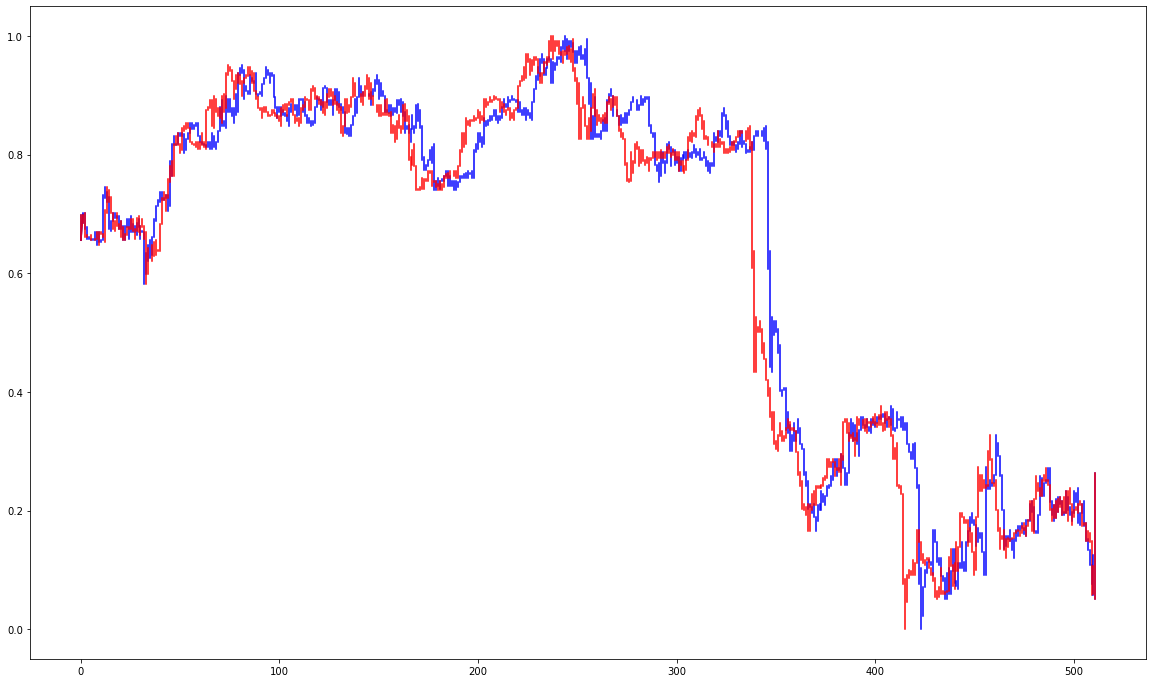

In [60]:
# Candles -> points
JIT_enabled = False

#@jit(nopython=True, parallel=False)
def candlesToPoints(candles, ds_size=-1):

    point_sequence = candles[:ds_size, 0:2].flatten()                           # create HLHLHL... sequence                              
    
    mask = np.ones(point_sequence.shape, np.bool8)
    
    for i in range(len(point_sequence)-1):                                     # remove double H/Ls using mask
        if point_sequence[i] == point_sequence[i+1]:
            mask[i] = False
            
    point_sequence = point_sequence[mask]                                       # apply mask
    mask = np.ones(point_sequence.shape, np.bool8)
    
    for i in range(len(point_sequence)-3):                                     # remove double moves
        if not mask[i]:
            continue
        
        if (point_sequence[i] == point_sequence[i+2]) and (point_sequence[i+1] == point_sequence[i+3]):
            mask[i] = False
            mask[i+1] = False
            
    return point_sequence[mask] 
    

def fixGaps(candles):
  
    candle_count = candles.shape[0]
    
    for i in range(candle_count-1):
        c1, c2 = candles[i], candles[i+1]
        
        if c2[1] < c1[0]:                       # second candle high is lower than first candle low
            candles[i+1, 1] = c1[0]             # fill the gap
            
        if c2[0] > c1[1]:                       # second candle low is higher than first candle high
            candles[i+1, 0] = c1[1]
    
    return candles





# M1 Candles -> M15 candles
@tf.function(jit_compile=JIT_enabled)
def convertToTimeframe(candles, TF = 15):
    candles_count = tf.shape(candles)[0] // TF      

    tmp = candles[:candles_count*TF]
    
    tmp = tf.reshape(tmp, [candles_count, TF, candles.shape[1]])[:, :, :2]     # split into 15m intervals  (N,15,2)
    tmp = tf.reshape(tmp, [candles_count, TF * 2]) # flatten last two axes to (N, 30), this contains both highs and lows

    lows = tf.reduce_min(tmp, axis=-1, keepdims=True)             
    highs = tf.reduce_max(tmp, axis=-1, keepdims=True)

    return tf.concat((lows, highs), axis=1)




@tf.function(jit_compile=JIT_enabled)
def vec2fourier(seq, emb_dim=8):
    sequence_length = tf.shape(seq)[0]
    seq = tf.reshape(seq, [-1])
    
    x = tf.cast(seq * 3.14159265358, dtype=tf.float32)   # 0...2PI
    
    w = tf.range(emb_dim, delta=1, dtype=tf.float32)
    w = tf.math.pow(2.0, w)                         # 1, 2, 4, 8...
    
    w = tf.expand_dims(w, axis=0)
    w = tf.tile(w, multiples=(tf.shape(x)[0], 1)) 

    x = tf.expand_dims(x, axis=-1)
    x = tf.tile(x, multiples=(1, emb_dim)) 

    seq = tf.concat([tf.math.sin(x * w), tf.math.cos(x * w)], 1)
    
    seq = tf.reshape(seq, [sequence_length, -1])
    return seq






@tf.function(jit_compile=False)
def check_reaction(PA : tf.Tensor, entry : tf.float32, stop : tf.float32, RR = 2.0):          # exception for unnormalized PA
    """
    Input - price - normalized to 0-1
    Output - [Win_prob, Loss_prob]
    """
    
    seq_len = tf.shape(PA)[0]
    
    entry_size = tf.abs(entry-stop)
    tg = entry + RR * entry_size     # only for longs
    
    beyond_stop_inv = tf.greater(tf.reduce_min(PA, axis=1), stop)      # mask of points that are below stop level, inverted
    beyond_target_inv = tf.less(tf.reduce_max(PA, axis=1), tg)
    
    #tf.print("min_PA", tf.reduce_min(PA, axis=1))
    
    #tf.print("beyond stop", beyond_stop_inv)
    #tf.print("beyond target", beyond_target_inv)
    
    #tf.print("PA", tf.shape(PA))
    #tf.print("beyond", tf.shape(beyond_stop))

    indices_stop =   tf.cast(tf.range(0, seq_len, 1), tf.float32) + tf.cast(beyond_stop_inv, tf.float32)   * tf.cast(seq_len, tf.float32)   
    indices_target = tf.cast(tf.range(0, seq_len, 1), tf.float32) + tf.cast(beyond_target_inv, tf.float32) * tf.cast(seq_len, tf.float32)  
    # indices of values higher than stop get added a constant (seq_len) to it -> become higher than other indices

   
    stop_index = tf.cast(tf.reduce_min(indices_stop), tf.int32)
    tg_index   = tf.cast(tf.reduce_min(indices_target), tf.int32)
    
    #tf.print("stop/tg index", stop_index, tg_index)
    
    
    
    if (stop_index >= seq_len) and (tg_index >= seq_len):
        return tf.constant([1.0 / (1.0 + RR)])                      # neither stop nor target got hit
    
    if stop_index < tg_index:
        return tf.constant([0.0])                                   # stop hit first
    
    if stop_index > tg_index:
        return tf.constant([1.0])                                   # target hit first
    
    return tf.constant([1.0 / (1.0 + RR)])                          # both stop and tg hit in a single candle (stop_index == tg_index) -> can't tell
    
    





@tf.function(jit_compile=JIT_enabled)
def amplitudeAugment(x : tf.Tensor):

    shift = tf.random.uniform(shape=(1, 1), minval=0.0, maxval=2.0, dtype=model_dtype) 
    mul = tf.random.uniform(shape=(1, 1), minval=0.6, maxval=1.4, dtype=model_dtype)    
    
    shift = tf.tile(shift, multiples=(tf.shape(x)[-2], tf.shape(x)[-1]))        # expand the last dimension
    mul = tf.tile(mul, multiples=(tf.shape(x)[-2], tf.shape(x)[-1]))            # expand the last dimension
    
    return tf.multiply(x, mul) + shift



@tf.function(jit_compile=JIT_enabled)
def ratioAugment(x : tf.Tensor):
    boundary = tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0, dtype=model_dtype) 
    shift = tf.random.uniform(shape=(1,), minval=-0.5, maxval=0.5, dtype=model_dtype) 
    
    x_shape = tf.shape(x)
    x = tf.reshape(x, [-1]) # flatten
    
    mask = tf.cast(tf.math.greater(x, boundary), dtype=model_dtype) # draw price boundary

    boundary_expanded = tf.tile(tf.expand_dims(boundary, axis=-1), multiples=(1, tf.shape(x)[-1]))
    tmp = tf.math.multiply(x - boundary_expanded, shift)                # Center at boundary, then mult
    
    x = x * (1.0 + tf.math.multiply(mask, tmp)) 
    
    x = tf.reshape(x, x_shape)    # reshape back to original, now we can look at H/Ls separately
    
    max_amp = tf.reduce_max(x)          # now normalize back to [0, 1]
    min_amp = tf.reduce_min(x)
    
    return (x - min_amp) / (max_amp - min_amp + 1e-6)




@tf.function(jit_compile=False)
def timeStretchAugment(x : tf.Tensor, min_TF : tf.int32, max_TF : tf.int32, output_length : tf.int32):
    
    input_size = tf.shape(x)[0]    
    
    intervals = tf.cast(tf.random.uniform(shape=(output_length-1,), minval=min_TF, maxval=max_TF, dtype=tf.int32), tf.float32)  # leave one slot for adjustment
    
    interval_lengths = intervals * tf.cast(input_size-2, tf.float32) / tf.reduce_sum(intervals) # one for adjustment, don't want to have very small interval
    intervals = tf.cast(tf.math.floor(interval_lengths), tf.int32)
    
    adjust_amount = tf.expand_dims(input_size - tf.reduce_sum(intervals), axis=0)   # calculate residual interval
    intervals = tf.concat([intervals, adjust_amount], axis=0)

    slices = tf.RaggedTensor.from_row_lengths(x, intervals, validate=False)  
    
    
    c_min = tf.cast(tf.math.reduce_min(slices, axis=1, keepdims=False), dtype=tf.float32)              # compute H/Ls, keepdims=False doesn't work for some reason
    c_max = tf.cast(tf.math.reduce_max(slices, axis=1, keepdims=False), dtype=tf.float32)
    
    res = tf.concat([c_min, c_max], axis=1)
    
    c_min = tf.math.reduce_min(res, axis=1, keepdims=True)         
    c_max = tf.math.reduce_max(res, axis=1, keepdims=True)

    return tf.concat([c_min, c_max], axis=1)

    
      
    



    
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################


#       Napady
#   BarlowTwins augmentation - jedna PA, 2 nebo vic augmentovanych verzi musi mit stejny embedding vektor
#
#


@tf.function(jit_compile=False)
def simple_aug(x : tf.Tensor): 
    
    max_amp = tf.reduce_max(x)          # now normalize back to [0, 1]
    min_amp = tf.reduce_min(x)
    
    x = (x - min_amp) / (max_amp - min_amp + 1e-6)

    for i in tf.range(5):   # 5 times
        x = ratioAugment(x)
        
    return x





################################################################################################################################

    


@tf.function(jit_compile=False) # random sequencing doesn't work with JIT
def get_random_seq(samples : tf.Tensor) -> tf.Tensor:       

    dataset_size = tf.shape(samples)[0]
    sequence_length = 512 * 15
    
    
    i = tf.random.uniform([], minval=0, maxval=dataset_size - sequence_length * 2 - 1, dtype=tf.int32)
     
    seq = samples[i:(i+sequence_length)]
    
    direction_flip = tf.cast(tf.squeeze(tf.random.uniform([], minval=0.0, maxval=1.0, dtype=tf.float32)) > 0.5, tf.float32) * 2.0 - 1.0	# result either -1.0 or 1.0
    seq = seq * direction_flip

    
    min_val = tf.math.reduce_min(seq)
    max_val = tf.math.reduce_max(seq)
    
    seq = (seq - min_val) / (max_val - min_val + 1e-6)
    seq = tf.cast(seq, dtype=tf.float32) 

    return seq      



    

@tf.function(jit_compile=False)
def get_random_trade(samples : tf.Tensor):      
    
    dataset_size = tf.shape(samples)[0]
    
    sequence_length = 128
    look_ahead_length = 512     # how far in future to look for reaction
    
    timeframes = tf.constant([225, 15])       # in minutes, descending order
    
    ################# Pick random place
    
    left_index_boundary = sequence_length*timeframes[0]
    right_index_boundary = dataset_size - look_ahead_length - 1
    
    i = tf.squeeze(tf.random.uniform([], minval=left_index_boundary, maxval=right_index_boundary, dtype=tf.int32))  # anchor, where PA ends (where the trade is taken) starts
    
    
    ################# Gather data
    
    LTF_PA = samples[i-sequence_length*timeframes[1]:i+look_ahead_length*timeframes[1]]   # take both LTF PA and Future PA so we can normalize them together, then separate again
    HTF_PA = samples[i-sequence_length*timeframes[0]:i]
    
    
    ################# Augmentations
    
    LTF_PA = timeStretchAugment(LTF_PA, min_TF=7, max_TF = 23, output_length = sequence_length+look_ahead_length)
    HTF_PA = timeStretchAugment(HTF_PA, min_TF=7, max_TF = 23, output_length = sequence_length)
	

    #TF = tf.cast(tf.shape(HTF_PA)[0] // sequence_length, tf.int32)
    #HTF_PA = convertToTimeframe(HTF_PA, TF = TF)

    LTF_PA = simple_aug(LTF_PA)
    HTF_PA = simple_aug(HTF_PA)
    
    ################# Align future PA
    
    future_PA = LTF_PA[sequence_length:]
    LTF_PA = LTF_PA[:sequence_length]
    
    # Normalize the whole sequence so pred_PA is in the range 0-1
    min_val = tf.math.reduce_min(LTF_PA)
    max_val = tf.math.reduce_max(LTF_PA)
    
    LTF_PA = (LTF_PA - min_val) / (max_val - min_val + 1e-6)                      # normalizujeme PA a Future_PA do stejnych souradnic
    future_PA = (future_PA - min_val) / (max_val - min_val + 1e-6)
    # Use values from pred_PA to normalize future_PA
    

    
    ################# Align PA so most recent value is 0
    
    LTF_entry = tf.random.uniform([], minval=LTF_PA[-1, 0], maxval=LTF_PA[-1, 1], dtype=tf.float32)         # entry inside the last candle H and L
    #LTF_entry = minval=LTF_PA[-1, 0] - 0.01
    
    LTF_PA = (LTF_PA - LTF_entry)   # so entry will always be at price 0.0 
    future_PA = (future_PA - LTF_entry)  
    
    HTF_entry = tf.random.uniform([], minval=HTF_PA[-1, 0], maxval=HTF_PA[-1, 1], dtype=tf.float32)
    HTF_PA = (HTF_PA - HTF_entry)
    
    
    
	################# Randomly flip the chart to account for shorts as well
	
	
    direction_flip = tf.cast(tf.squeeze(tf.random.uniform([], minval=0.0, maxval=1.0, dtype=tf.float32)) > 0.5, tf.float32) * 2.0 - 1.0	# result either -1.0 or 1.0
    
    #direction_flip = 1.0
    HTF_PA = HTF_PA * direction_flip
    LTF_PA = LTF_PA * direction_flip
    future_PA = future_PA * direction_flip
	
	
	
    ################# Generate entry, stop levels and check the outcome of this trade (only on LTF)
    min_stop_size = 0.1
    max_stop_size = 0.3
    RR = 1.0
    
    entry_size = tf.random.uniform([], minval=min_stop_size, maxval=max_stop_size, dtype=tf.float32)
    #entry_size = LTF_PA[-1, 1] + 0.01
    
    stop = -entry_size    
    target = entry_size * RR
    
    trade_result = check_reaction(future_PA, entry=0.0, stop=stop, RR=RR)   # entry always at 0.0
    
    
    
    
    ################# Now create embeddings
    indices_embedding = tf.cast(tf.expand_dims(tf.range(sequence_length) / sequence_length, axis=-1), tf.float32)
    
    LTF_embedding = tf.concat([LTF_PA, indices_embedding], axis=-1)
    HTF_embedding = tf.concat([HTF_PA, indices_embedding], axis=-1)
    
    return HTF_embedding, LTF_embedding, trade_result, tf.stack([stop, target])        #prices_embedding     #tf.stack([entry, stop])       #, unaugmented_PA



    

    

#HTF_PA, LTF_PA, trade_result, levels = get_random_trade(M15_candles)  


























    
    
    
    
    
    

print("BEGIN TEST   \n\n")

x = get_random_seq(M15_candles)
x = tf.expand_dims(x, axis=0)

dyn = DynamicIntervals(512, min_TF=3, max_TF=40)
ratio = RatioAugment()

x1 = dyn(x)
x2 = dyn(x)

N_augment = 5

#for i in range(N_augment):
#    x1 = ratio(x1)

#for i in range(N_augment):
#    x2 = ratio(x2)





x1 = x1[0]
x2 = x2[0]


fig = plt.figure(figsize=(20, 12))
plt.plot(x1[0], color="blue")
plt.plot(x2[0], color="red")

for i in range(x1.shape[0]):
    plt.plot((i, i), (x1[i, 0], x1[i, 1]), color="blue")
    plt.plot((i, i), (x2[i, 0], x2[i, 1]), color="red")

 




In [53]:
print(x1[210:250])

tf.Tensor(
[[0.7642336  0.8009724 ]
 [0.76675844 0.78413993]
 [0.7642336  0.8009724 ]
 [0.77178067 0.77675796]
 [0.75400853 0.7816905 ]
 [0.77427495 0.7816905 ]
 [0.76675844 0.7816905 ]
 [0.751424   0.7816905 ]
 [0.7616942  0.77178067]
 [0.7642336  0.7914187 ]
 [0.76675844 0.7865754 ]
 [0.7792298  0.78900266]
 [0.7692752  0.7816905 ]
 [0.77675796 0.7792298 ]
 [0.76675844 0.7792298 ]
 [0.751424   0.77178067]
 [0.75400853 0.75400853]
 [0.75400853 0.75400853]
 [0.75400853 0.75400853]
 [0.75400853 0.75400853]
 [0.75400853 0.75400853]
 [0.75400853 0.82181937]
 [0.8126638  0.8285742 ]
 [0.7914187  0.8195463 ]
 [0.7816905  0.78900266]
 [0.77178067 0.7816905 ]
 [0.7642336  0.7792298 ]
 [0.7616942  0.77427495]
 [0.77427495 0.77675796]
 [0.77427495 0.7938238 ]
 [0.77427495 0.79860055]
 [0.7914187  0.7962176 ]
 [0.7938238  0.81034684]
 [0.79860055 0.82181937]
 [0.7962176  0.82181937]
 [0.80333036 0.80568016]
 [0.79860055 0.8126638 ]
 [0.808019   0.85038555]
 [0.81726474 0.8285742 ]
 [0.81034684 0

In [125]:
# M15 dataset



M15_data = tf.data.Dataset.from_tensor_slices([M15_candles])

M15_data = (
    M15_data.repeat()
    .map(get_random_trade, num_parallel_calls=8, deterministic=False)       # get_random_seq_diffusion  get_dummy_seq  get_random_trade
    .filter(lambda x,y, result, lvl: tf.reduce_any(tf.equal(result, [0.0, 1.0])))
)



M15_test_data = tf.data.Dataset.from_tensor_slices([M15_test_candles])

M15_test_data = (
    M15_test_data.repeat()
    .map(get_random_trade, num_parallel_calls=8, deterministic=False)    
    .filter(lambda x,y, result, lvl: tf.reduce_any(tf.equal(result, [0.0, 1.0])))
)



#M15_data = tf.data.Dataset.zip((M15_data, M15_data))


In [8]:
from keras.callbacks import TensorBoard
exp_name = "test_monte_carlo_8"

                
callbacks = [EarlyStopping(monitor='loss',
                           patience=400,
                           verbose=1,
                           mode='min'),
             ReduceLROnPlateau(monitor='loss',
                               factor=0.1,
                               patience=100,
                               verbose=1,
                               min_delta=0.00001,
                               mode='min'),
             TerminateOnNaN()]

#%load_ext tensorboard
#%tensorboard --logdir gdrive/Shareddrives/edu_VAD/Anton/VAD_project/logs,   TensorBoard(log_dir= projDir + './logs', histogram_freq=0, write_graph=True)

#              ModelCheckpoint(monitor='accuracy',
#                             filepath= projDir + 'weights/{}'.format(exp_name) + '_{epoch:04d}.hdf5',
#                             save_best_only=False,
#                             save_freq=50,      # every 5 epochs
#                             save_weights_only=True,
#                             mode='max')

#encoder.save_weights(projDir + 'encoder_4.hdf5')
#predictor.save_weights(projDir + 'predictor_4.hdf5')


In [9]:
# Architecture


with tf.device(DEVICE):

    K.clear_session()
    
    
    class ScaleNorm(Layer):
        def __init__(self):
            super(ScaleNorm, self).__init__()
            
        @tf.function(jit_compile=False)
        def call(self, x):
            scale = tf.reduce_max(tf.abs(x), axis=0)
            return x / (scale + 1e-8)


    
    class TransformerBlock(Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
            super(TransformerBlock, self).__init__()

            self.num_heads = num_heads
            self.embed_dim = embed_dim
            self.ff_dim = ff_dim
            self.dropout_rate = rate

            self.att = fast_attention.Attention(num_heads=num_heads, hidden_size=embed_dim, attention_dropout=rate)
            #self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
            
            self.ffn = Sequential(
                [Dense(ff_dim, activation="ReLU", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),        # LeakyReLU
                 Dense(embed_dim, kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),]
            )
            self.norm1 = ScaleNorm()
            self.norm2 = ScaleNorm()
            self.dropout1 = Dropout(rate)
            self.dropout2 = Dropout(rate)

        @tf.function(jit_compile=False, experimental_follow_type_hints=True)
        def call(self, inputs, training=True):
            attn_output = self.att(inputs, inputs, bias=None)      # , bias=None
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.norm1(inputs + attn_output)                    # layernorm
            ffn_output = self.ffn(out1)    
            ffn_output = self.dropout2(ffn_output, training=training)
            return self.norm2(inputs + out1 + ffn_output)     

        def get_config(self):
            cfg = super(TransformerBlock, self).get_config()
            cfg.update({'num_heads': self.num_heads,
                        'embed_dim': self.embed_dim,
                        'ff_dim': self.ff_dim,
                        'dropout_rate': self.dropout_rate})
            return cfg
        
        
        
        
        
    


    class PositionEmbedding(Layer):
        def __init__(self, maxlen, embed_dim):
            super(PositionEmbedding, self).__init__()
            self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
            self.maxlen = maxlen

        @tf.function(jit_compile=False)
        def call(self, x):
            #maxlen = tf.shape(x)[-1]
            positions = tf.range(start=0, limit=self.maxlen, delta=1)
            positions = self.pos_emb(positions)
            return x + positions

        def get_config(self):
            cfg = super(PositionEmbedding, self).get_config()
            cfg.update({'pos_emb': self.pos_emb,
                        'maxlen': self.maxlen})
            return cfg
        
        
    
    class InstanceNorm(Layer):
        def __init__(self):
            super(InstanceNorm, self).__init__()


        @tf.function(jit_compile=False)
        def call(self, x):

            return (x - tf.reduce_mean(x, axis=0)) / (tf.math.reduce_std(x, axis=0) + 1e-8)

    
    


    def FFT_loss_1D(y_true, y_pred):
            
        spec1 = tf.signal.fft(tf.cast(y_true, dtype=tf.dtypes.complex64)) / (y_true.shape[-1] ** 0.5)
        spec2 = tf.signal.fft(tf.cast(y_pred, dtype=tf.dtypes.complex64)) / (y_pred.shape[-1] ** 0.5)

        return  tf.math.reduce_mean(tf.math.log(1.0 + tf.cast(tf.abs(spec1-spec2), dtype=tf.float32))) * 100 


    
        

    class InvertedResidual1D(Layer):
        def __init__(self, filters, strides, expansion_factor=2, trainable=True,
                    name=None, **kwargs):
            super(InvertedResidual1D, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            self.strides = strides
            self.expansion_factor = expansion_factor	# allowed to be decimal value
            self.act = tf.nn.leaky_relu  #tf.nn.leaky_relu

        def build(self, input_shape):
            input_channels = int(input_shape[-1])
            
            l2_reg = 0.0
            
            self.ptwise_conv1 = Conv1D(filters=int(input_channels*self.expansion_factor), kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
        
            self.dwise = DepthwiseConv1D(kernel_size=3, strides=self.strides, padding='same', use_bias=True, 
                                        kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
            
            self.ptwise_conv2 = Conv1D(filters=self.filters, kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))

            self.bn1 = ScaleNorm()
            self.bn2 = ScaleNorm()
            self.bn3 = ScaleNorm()
            
            self.dropout1 = Dropout(0.1)
            self.dropout2 = Dropout(0.1)
            
        @tf.function(jit_compile=False)
        def call(self, input_x):

            x = self.ptwise_conv1(input_x)
            x = self.dropout1(x)
            x = self.bn1(x)
            x = self.act(x)
            
            x = self.dwise(x)
            x = self.dropout2(x)
            x = self.bn2(x)
            x = self.act(x)

            x = self.ptwise_conv2(x)


            if input_x.shape[1:] == x.shape[1:]:
                x = x + input_x                     #self.bn3(x + input_x)
            return x

        def get_config(self):
            cfg = super(InvertedResidual1D, self).get_config()
            cfg.update({'filters': self.filters,
                        'strides': self.strides,
                        'expansion_factor': self.expansion_factor})
            return cfg
        
        
        
    class ResConv1D(Layer):
        def __init__(self, filters, trainable=True,
                    name=None, **kwargs):
            super(ResConv1D, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            self.act = tf.nn.relu  #tf.nn.leaky_relu

        def build(self, input_shape):
                       
            
            self.residual = Conv1D(filters=self.filters, kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(12.0), bias_constraint=max_norm(12.0))
            
            self.conv = Conv1D(filters=self.filters, kernel_size=3, use_bias=True, padding="SAME",
                                       kernel_constraint=max_norm(12.0), bias_constraint=max_norm(12.0))
            

            self.norm = ScaleNorm()

        def call(self, input_x):
 
            x = self.conv(input_x)
            
            if input_x.shape[1] == x.shape[1]:
                x += self.residual(input_x)
            
            x = self.norm(x)
            x = self.act(x)
        
            return x


        def get_config(self):
            cfg = super(ResConv1D, self).get_config()
            cfg.update({'filters': self.filters})
            return cfg
    
    
    
    
    
    class RandomMask(Layer):
        def __init__(self, maxLen=64, masked_rate=0.75):
            super(RandomMask, self).__init__()

            self.maskedRate = masked_rate
            self.maxLen = maxLen
            self.trainable = False
 
        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            batch_size = tf.shape(inputs)[-3]   # or 0 ?
            mask = tf.random.uniform(shape=(batch_size, self.maxLen,), minval=0.0, maxval=1.0, dtype=model_dtype)      # stateless_uniform
            mask = tf.cast(tf.math.greater(mask, self.maskedRate), dtype=model_dtype) 
            
            mask = tf.expand_dims(mask, axis=-1)
            mask = tf.tile(mask, multiples=(1, 1, tf.shape(inputs)[-1]))        # expand the last dimension
            
            if training: 
                return tf.math.multiply(inputs, mask), mask
            
            return inputs, tf.ones(tf.shape(inputs))        # ones = no mask


        def get_config(self):
            cfg = super(RandomMask, self).get_config()
            cfg.update({'maskedRate': self.maskedRate,
                        'maxLen': self.maxLen})
            return cfg
        
    
    class RestoreUnmaskedTokens(Layer):
        def __init__(self, maxLen=64):
            super(RestoreUnmaskedTokens, self).__init__()

            self.maxLen = maxLen
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            reconstructed, original, mask = inputs
            
            rec = tf.math.multiply(reconstructed, 1.0 - mask)
            remain = tf.math.multiply(original, mask)
            
            if training: 
                return rec + remain
            
            return reconstructed


        def get_config(self):
            cfg = super(RestoreUnmaskedTokens, self).get_config()
            cfg.update({'maxLen': self.maxLen})
            return cfg
        
        
    
    class ConstantLayer(Layer):
        def __init__(self, latent_len = 128, embed_dim = 64, trainable=True, name=None, **kwargs):
            super(ConstantLayer, self).__init__(trainable=trainable, name=name, **kwargs)
            self.latent_len = latent_len
            self.embed_dim = embed_dim

        def build(self, input_shape):

            self.latent_array = self.add_weight(
                shape=(self.latent_len, self.embed_dim),
                initializer="random_normal",
                trainable=True,
            )                           
            
            
        def call(self, input_x):
            bs = tf.shape(input_x)[0]
            x = tf.expand_dims(self.latent_array, axis=0)
            
            return tf.tile(x, multiples=(bs, 1, 1))


        def get_config(self):
            cfg = super(ConstantLayer, self).get_config()
            cfg.update({'latent_len': self.latent_len, 
                        'embed_dim': self.embed_dim})
            return cfg
        
    
    
    
    class FourierEmbeddingLayer(Layer):
        def __init__(self, embed_dim = 8, trainable=False, name=None, **kwargs):
            super(FourierEmbeddingLayer, self).__init__(trainable=trainable, name=name, **kwargs)
            self.embed_dim = embed_dim // 2

        def build(self, input_shape):
            channel_count = input_shape[-1]
            self.input_len = input_shape[-2]  # sequence length
            
            self.w = tf.range(self.embed_dim, delta=1, dtype=tf.float32)
            self.w = tf.math.pow(2.0, self.w)                         # 1, 2, 4, 8...
            
            self.w = tf.reshape(self.w, [1, 1, 1, -1])       # set batch size to 1, this tensor will be tiled at runtime.    #tf.expand_dims(self.w, axis=0)
            self.w = tf.tile(self.w, multiples=(1, self.input_len, channel_count, 1)) 
                  
            
        @tf.function(jit_compile=False)
        def call(self, seq):
            batch_size = tf.shape(seq)[0]
            channel_count = tf.shape(seq)[-1]

            x = tf.cast(seq * 2.0 * 3.14159265358, dtype=tf.float32)   # 0...2PI

            x = tf.expand_dims(x, axis=-1)
            x = tf.tile(x, multiples=(1, 1, 1, self.embed_dim))  # expand [..., channels, 1] to [..., channels, emb_dim]
            
            w = tf.tile(self.w, multiples=(batch_size, 1, 1, 1)) # adjust for batch size

            seq = tf.concat([tf.math.sin(x * self.w), tf.math.cos(x * self.w)], -1)
            seq = tf.reshape(seq, [batch_size, self.input_len, channel_count*self.embed_dim*2])
            
            return seq


        def get_config(self):
            cfg = super(FourierEmbeddingLayer, self).get_config()
            cfg.update({'input_len': self.latent_len, 
                        'embed_dim': self.embed_dim})
            return cfg
        
    
    
    
    class AttentionPooling(Layer):
        def __init__(self, embed_dim=64, sequence_len=128, heads=4, trainable=True, name=None, **kwargs):
            super(AttentionPooling, self).__init__(trainable=trainable, name=name, **kwargs)
            self.sequence_len = sequence_len
            self.embed_dim = embed_dim
            self.heads = heads
            
            self.att = MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
            self.ffn = Sequential(
                [Dense(embed_dim*2, activation="ReLU", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),        # LeakyReLU
                 Dense(embed_dim, kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),]
            )
            self.layernorm = LayerNormalization(epsilon=1e-6)
            

        def build(self, input_shape):

            self.latent_array = self.add_weight(
                shape=(self.sequence_len, self.embed_dim),
                initializer="random_normal",
                trainable=True,
            )                           
            
        @tf.function(jit_compile=False)
        def call(self, x):
            batch_size = tf.shape(x)[0]

            const = tf.expand_dims(self.latent_array, axis=0)
            
            const = tf.tile(const, multiples=(batch_size, 1, 1))

            x = self.att(const, x)
            
            return self.layernorm(x + self.ffn(x))
            


        def get_config(self):
            cfg = super(AttentionPooling, self).get_config()
            cfg.update({'sequence_len': self.sequence_len, 
                        'embed_dim': self.embed_dim, 
                        'heads': self.heads})
            return cfg
        


emb = AttentionPooling(embed_dim=64, sequence_len=16, heads=4)      

x = tf.zeros([32, 128, 64])

x = emb(x)

tf.print(tf.shape(x))

    

[32 16 64]


In [126]:

################################ encoder


inp_dim = 3

sequence_length = 128
embed_dim = 32
fourier_dim = 8

patch_size = 4


################################
inp = Input(shape=[sequence_length, inp_dim])
x = inp    




x = FourierEmbeddingLayer(embed_dim=fourier_dim)(x)

x = Flatten()(x)

#x = InvertedResidual1D(16, 1, expansion_factor=4)(x)
#x = InvertedResidual1D(16, 2, expansion_factor=4)(x)

#x = GlobalAveragePooling1D()(x)

#x = Dense(128, activation = 'LeakyReLU')(x)
#x = Dense(128, activation = 'LeakyReLU')(x)

x = Dense(64, activation = 'LeakyReLU')(x)

#x = Dense(128, activation = 'LeakyReLU')(x)
x = Dense(64, activation = 'LeakyReLU')(x)






#x = InvertedResidual1D(32, 2, expansion_factor=2)(x)

#x = InvertedResidual1D(32, 2, expansion_factor=2)(x)

#x = Dense(128, activation = 'LeakyReLU')(x)
#x = Dense(64, activation = 'LeakyReLU')(x)
#x = PositionEmbedding(sequence_length // patch_size, 64)(x)

#x = TransformerBlock(64, 2, 128)(x)
#x = TransformerBlock(64, 2, 128)(x)
#x = TransformerBlock(64, 2, 128)(x)
#x = AttentionPooling(embed_dim=embed_dim, sequence_len=32, heads=4)(x)

#x = Dense(out_dim, activation = 'LeakyReLU')(x)

#x = GlobalAveragePooling1D()(x)
#x = GlobalMaxPooling1D()(x)
#x = LayerNormalization()(x)

#x = Flatten()(x)
#x = LayerNormalization()(x)


#x = Dense(128, activation = 'LeakyReLU')(x)




outp = x

encoder = Model(inp, outp, name="encoder")



#encoder.compile(optimizer=opt, loss=FFT_loss_1D, metrics=[tf.keras.metrics.MeanSquaredError(), FFT_loss_1D])     # tf.keras.losses.MSE
encoder.build(input_shape=[None, sequence_length, inp_dim])
#encoder.load_weights('encoder_5.hdf5', by_name=True, skip_mismatch=True) 

#encoder.layers[2].trainable = False  # Freeze the layer
#encoder.trainable = False

encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 128, 3)]          0         
                                                                 
 fourier_embedding_layer_25   (None, 128, 24)          0         
 (FourierEmbeddingLayer)                                         
                                                                 
 flatten_21 (Flatten)        (None, 3072)              0         
                                                                 
 dense_150 (Dense)           (None, 64)                196672    
                                                                 
 dense_151 (Dense)           (None, 64)                4160      
                                                                 
Total params: 200,832
Trainable params: 200,832
Non-trainable params: 0
_____________________________________________________

In [127]:

################################ predictor

inp_dim = 64

inp1 = Input(shape=[inp_dim])
inp2 = Input(shape=[inp_dim])
#inp3 = Input(shape=[inp_dim])

levels = Input(shape=[2])


x1 = Dense(16, activation = 'LeakyReLU')(inp1)
#x1 = Dense(128, activation = 'LeakyReLU')(x1)
#x1 = Dense(64, activation = 'LeakyReLU')(x1)

x2 = Dense(16, activation = 'LeakyReLU')(inp2)
#x2 = Dense(128, activation = 'LeakyReLU')(x2)
#x2 = Dense(64, activation = 'LeakyReLU')(x2)


price_emb = Reshape([1, 2])(levels)
price_emb = FourierEmbeddingLayer(embed_dim=8)(price_emb)

price_emb = Dense(32, activation = 'LeakyReLU')(price_emb)
price_emb = Dense(32, activation = 'LeakyReLU')(price_emb)
price_emb = Flatten()(price_emb)


x = Concatenate(axis=-1)([x1, x2, price_emb]) 
x = ScaleNorm()(x)

#x = Dense(256, activation = 'LeakyReLU')(x)
#x = Dense(128, activation = 'LeakyReLU')(x)
#x = ScaleNorm()(x)

x = Dense(64, activation = 'LeakyReLU')(x)
x = Dense(32, activation = 'LeakyReLU')(x)
x = Dense(1, activation = 'sigmoid')(x)

outp = x

predictor = Model([inp1, inp2, levels], outp, name="predictor")



#encoder.compile(optimizer=opt, loss=FFT_loss_1D, metrics=[tf.keras.metrics.MeanSquaredError(), FFT_loss_1D])     # tf.keras.losses.MSE
predictor.build(input_shape=[[None, inp_dim], [None, inp_dim], [None, 2]])
#predictor.load_weights('predictor_5.hdf5', by_name=True, skip_mismatch=True) 

predictor.summary()




Model: "predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 reshape_14 (Reshape)           (None, 1, 2)         0           ['input_57[0][0]']               
                                                                                                  
 fourier_embedding_layer_26 (Fo  (None, 1, 16)       0           ['reshape_14[0][0]']             
 urierEmbeddingLayer)                                                                             
                                                                                                  
 dense_154 (Dense)              (None, 1, 32)        544         ['fourier_embedding_layer

In [128]:

class AEModel(keras.Model):

    def __init__(self, encoder, predictor):
        super(AEModel, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        #self.loss_tracker = keras.metrics.Mean(name="loss")


    #@property
    #def metrics(self):
    #    return [self.loss_tracker]
    
    
    
    @tf.function(jit_compile=False)
    def call(self, inp):
        
        HTF, LTF, levels = inp
        
        enc_HTF = self.encoder(HTF, training=False)
        #enc_MTF = self.encoder(MTF, training=False)
        enc_LTF = self.encoder(LTF, training=False)
        
        pred = self.predictor([enc_HTF, enc_LTF, levels], training=False)
        
        return pred         
    
    
    

    @tf.function(jit_compile=False)
    def train_step(self, batch):

        HTF, LTF, result, levels = batch 
        
        with tf.GradientTape() as tape:
            enc_HTF = self.encoder(HTF, training=True)
            #enc_MTF = self.encoder(MTF, training=True)
            enc_LTF = self.encoder(LTF, training=True)
            
            pred = self.predictor([enc_HTF, enc_LTF, levels], training=True)
            
            loss = self.compiled_loss(result, pred)   		#self.loss(result, pred), regularization_losses=self.losses   
            
            #loss += sum(self.encoder.losses) + sum(self.predictor.losses)   # Add any extra losses created during the forward pass.

  
        learnable_params = (self.encoder.trainable_variables 
                            + self.predictor.trainable_variables)

        grads_model = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(grads_model, learnable_params))
        
        #self.loss_tracker.update_state(loss)

        self.compiled_metrics.update_state(result, pred)
        return {m.name: m.result() for m in self.metrics}
		
        #return {"loss": self.loss_tracker.result()}
    





model = AEModel(encoder, predictor)

class GCLAMB(LAMB):
    def get_gradients(self, loss, params):  # gradient centralization
        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads


#SWA = tfa.optimizers.SWA
opt = GCLAMB(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=[keras.metrics.Recall(thresholds=0.333333), 
                                                                      keras.metrics.Precision(thresholds=0.333333), 
																	  keras.metrics.TruePositives(thresholds=0.4), 
                                                                      keras.metrics.FalsePositives(thresholds=0.4)])     # tf.keras.losses.binary_crossentropy, tf.keras.losses.MSE, tf.keras.losses.MeanAbsoluteError(), FFT_loss_1D
model.build(input_shape=[[None, sequence_length, 3], [None, sequence_length, 3], [None, 2]])

model.summary()



class SAMModel(tf.keras.Model):
    def __init__(self, orig_model, rho=0.05):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.orig_model = orig_model
        self.rho = rho

    @tf.function(jit_compile=False)
    def train_step(self, data):
        #(images, labels) = data
        HTF, LTF, result, levels = data 
        inp = [HTF, LTF, levels]
        
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.orig_model(inp, training=True)
            loss = self.compiled_loss(result, predictions)
			
        trainable_params = self.orig_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.orig_model(inp, training=True)
            loss = self.compiled_loss(result, predictions)    
        
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        
        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))
        
        self.compiled_metrics.update_state(result, predictions)
        return {m.name: m.result() for m in self.metrics}



    def test_step(self, data):
        (images, labels) = data
        predictions = self.orig_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm
		
  

SAM_model = SAMModel(model)
SAM_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[keras.metrics.Recall(thresholds=0.6), 
                                                                      keras.metrics.Precision(thresholds=0.6), 
																	  keras.metrics.TruePositives(thresholds=0.6), 
                                                                      keras.metrics.FalsePositives(thresholds=0.6)])




Model: "ae_model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 64)                200832    
                                                                 
 predictor (Functional)      (None, 1)                 9953      
                                                                 
Total params: 210,785
Trainable params: 210,785
Non-trainable params: 0
_________________________________________________________________


In [121]:



#x = InvertedResidual(64, (1, 1), expansion_factor=6)(x)
#kernel_constraint=max_norm(2.0)
#x = Conv2DTranspose(32, kernel_size=(3, inp_dim), strides=(2, 1), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="SAME")(x)
#x = Conv2D(32, (3, inp_dim), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="same")(x)
#x = Conv2DTranspose(1, kernel_size=1, strides=1, activation="linear", padding="SAME", dtype='float32')(x)
#x = Cropping1D([0, predict_len])(x)
#x = GlobalAveragePooling1D()(x)
# Dense(32, activation = 'LeakyReLU', kernel_regularizer=l2(0.01))
# Reshape([64, 129])
# Conv1D(32, 9, activation='relu', input_shape=[129])
# Dropout(p)
# BatchNormalization()
# Permute((2, 1), input_shape=(64, 129))
# LSTM(64, return_sequences = True)
# Flatten()
# GRU(64, return_sequences = True)
# Concatenate(axis=1)([x, y]) 
# Reshape([-1, 128])(inp)
#x = Rescaling(scale=1.0/255.0)(x)
#outp = tf.cast(x, tf.dtypes.float16) # Rescaling(scale=255.0)(x)
#x = GaussianNoise(0.2)(x)
#x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#outp = Dense(len(POSSIBLE_LABELS), activation="softmax")(x)
#x = PositionEmbedding(timesteps, embed_dim)(x)
#x = RandomMask(maxLen=timesteps, masked_rate=0.3)(x)
#x = RestoreUnmaskedTokens()([x, mask_input, mask])
#x = RepeatVector(28, input_shape=[30])(x)  # 28x vector
#x = TimeDistributed(Dense(28, activation="sigmoid"))(x)
#x = ActivityRegularization(l1=1e-3)(x)
#x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu")

#print(x.shape)

"""
for l in model.layers:
    print(lay.name, lay.output_shape)
"""

'\nfor l in model.layers:\n    print(lay.name, lay.output_shape)\n'

In [131]:
# train
gc.collect()

K.set_value(model.optimizer.learning_rate, 0.0001)
batch_size = 64

try:
    batched_DS = M15_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    hist = model.fit(batched_DS, callbacks=callbacks,
                    batch_size = batch_size, epochs = 4000, steps_per_epoch = 500)  # initial_epoch , validation_data=(valX[:32], valX[:32])
    
    plt.plot(hist.history["loss"])
    plt.title("Loss curve")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
except KeyboardInterrupt:
    print("\n Interrupted")




#model.save_weights(projDir + 'weights/test_2.hdf5')
#model.save(projDir + 'models/' + exp_name)

Epoch 1/4000
377/500 [=====================>........] - ETA: 15s - loss: 0.6963 - recall_32: 0.9998 - precision_32: 0.4985 - true_positives_32: 11892.0000 - false_positives_32: 11961.0000
 Interrupted


In [135]:
# Eval on train dataset

BS = 128000

batched_DS = M15_data.batch(BS)



tf.print("Generating dataset")
for i in batched_DS.take(1):        # only one batch
    HTF_PA = i[0]
    LTF_PA = i[1]
    res = i[2]
    levels = i[3]
    
tf.print("Dataset prepared")


win_probs_orig = tf.cast(tf.squeeze(res[:] > 0.99), tf.float32)      # only 0 or 1
loss_probs_orig = tf.cast(tf.squeeze(res[:] < 0.01), tf.float32)      # only 0 or 1

wins = tf.reduce_sum(win_probs_orig)
losses = tf.reduce_sum(loss_probs_orig)
    
tf.print("Successful trades:", wins, "out of", BS, "trades")
tf.print("Lost trades:", losses, "out of", BS, "trades")
tf.print("Can't tell cases:", BS - wins - losses)

tf.print("Real successful trades ratio:", wins / (wins + losses), "\n\n")



take_trade_ratio = 0.1



prediction = model([HTF_PA, LTF_PA, levels], training=True)

win_probs_pred = tf.squeeze(prediction[:, 0]) 
result = tf.math.top_k(win_probs_pred, sorted=False, k=int(BS * take_trade_ratio)).values

tf.print("Min/max probability of taken trades", tf.reduce_min(result), tf.reduce_max(result))


mask = tf.cast(win_probs_pred > tf.reduce_min(result), tf.float32)
win_count = tf.reduce_sum(win_probs_orig * mask)


tf.print("NN wins", win_count, "out of", int(BS * take_trade_ratio))
tf.print("Winrate:", win_count / int(BS * take_trade_ratio) * 100.0, "%")







Generating dataset
Dataset prepared
Successful trades: 63669 out of 128000 trades
Lost trades: 64331 out of 128000 trades
Can't tell cases: 0
Real successful trades ratio: 0.497414052 


Min/max probability of taken trades 0.528877735 0.593997121
NN wins 6515 out of 12800
Winrate: 50.8984375 %


In [101]:
# Eval on test dataset

BS = 16000

batched_DS = M15_test_data.batch(BS)



tf.print("Generating dataset")
for i in batched_DS.take(1):        # only one batch
    HTF_PA = i[0]
    LTF_PA = i[1]
    res = i[2]
    levels = i[3]
    
tf.print("Dataset prepared")


win_probs_orig = tf.cast(tf.squeeze(res[:] > 0.99), tf.float32)      # only 0 or 1
loss_probs_orig = tf.cast(tf.squeeze(res[:] < 0.01), tf.float32)      # only 0 or 1

wins = tf.reduce_sum(win_probs_orig)
losses = tf.reduce_sum(loss_probs_orig)
    
tf.print("Successful trades:", wins, "out of", BS, "trades")
tf.print("Lost trades:", losses, "out of", BS, "trades")
tf.print("Can't tell cases:", BS - wins - losses)

tf.print("Real successful trades ratio:", wins / (wins + losses), "\n\n")



take_trade_ratio = 0.01



prediction = model([HTF_PA, LTF_PA, levels], training=True)

win_probs_pred = tf.squeeze(prediction[:, 0]) 


result = tf.math.top_k(win_probs_pred, sorted=False, k=int(BS * take_trade_ratio))
win_indices = result.indices

tf.print("Min/max probability of taken trades", tf.reduce_min(result.values), tf.reduce_max(result.values))


mask = tf.cast(win_probs_pred > tf.reduce_min(result.values), tf.float32)
simulation_result = win_probs_orig * mask


win_count = tf.reduce_sum(simulation_result)
tf.print("NN wins", win_count, "out of", int(BS * take_trade_ratio))


tf.print("Winrate:", win_count / int(BS * take_trade_ratio) * 100.0, "%")



Generating dataset
Dataset prepared
Successful trades: 7940 out of 16000 trades
Lost trades: 8060 out of 16000 trades
Can't tell cases: 0
Real successful trades ratio: 0.49625 


Min/max probability of taken trades 0.560781598 0.63259685
[3655 14859 1580 ... 9628 5419 15733]
NN wins 106 out of 160
Winrate: 66.25 %


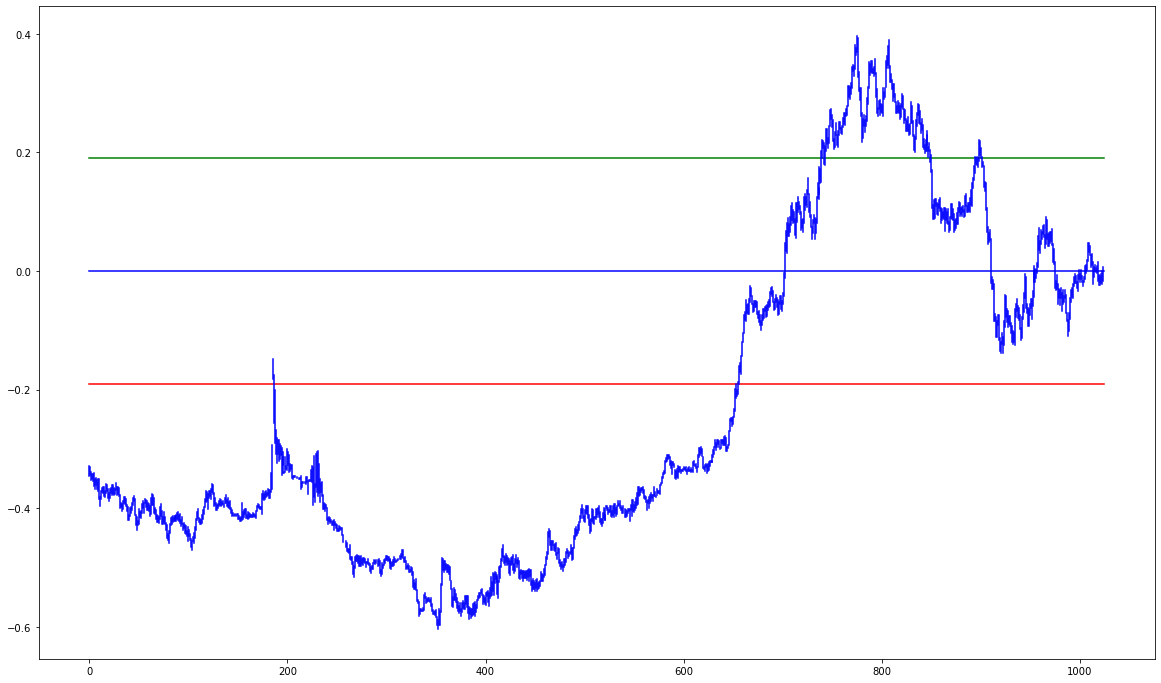

In [112]:
# Visualize won trades

i = tf.squeeze(tf.random.uniform([], minval=0, maxval=win_indices.shape[0], dtype=tf.int32))  # anchor, where PA ends (where the trade is taken) starts
    

PA = LTF_PA[i]
entry_stop = levels[i]



fig = plt.figure(figsize=(20, 12))

plt.plot((0, PA.shape[0]), (entry_stop[1], entry_stop[1]), color="green")
plt.plot((0, PA.shape[0]), (0.0, 0.0), color="blue")
plt.plot((0, PA.shape[0]), (entry_stop[0], entry_stop[0]), color="red")

for i in range(PA.shape[0]):
    plt.plot((i, i), (PA[i, 0], PA[i, 1]), color="blue")


In [26]:
#print(prediction)
tf.print("Wins/losses - min:", tf.reduce_min(prediction, axis=0), " max:", tf.reduce_max(prediction, axis=0))
tf.print("Std", tf.math.reduce_std(prediction, axis=0))

Wins/losses - min: [0.406876326]  max: [0.705797315]
Std [0.0620759092]


In [517]:
# Dummy test


BS = 8192

batched_DS = M15_data.batch(BS).prefetch(tf.data.AUTOTUNE)



for i in batched_DS.take(1):        # only one batch
    x = i[0]
    noisy_res = i[1]
    res = i[2]



prediction = model(x, training=False)




tf.print("Train loss with noisy targets", tf.reduce_mean(tf.square(prediction - noisy_res)))
tf.print("Loss with real denoised targets", tf.reduce_mean(tf.square(prediction - res)))
tf.print("Prediction mean", tf.reduce_mean(prediction))



#tf.print(prediction[:6, 0])



Train loss with noisy targets 0.251463175
Loss with real denoised targets 0.0282610357
Prediction mean 0.492108047


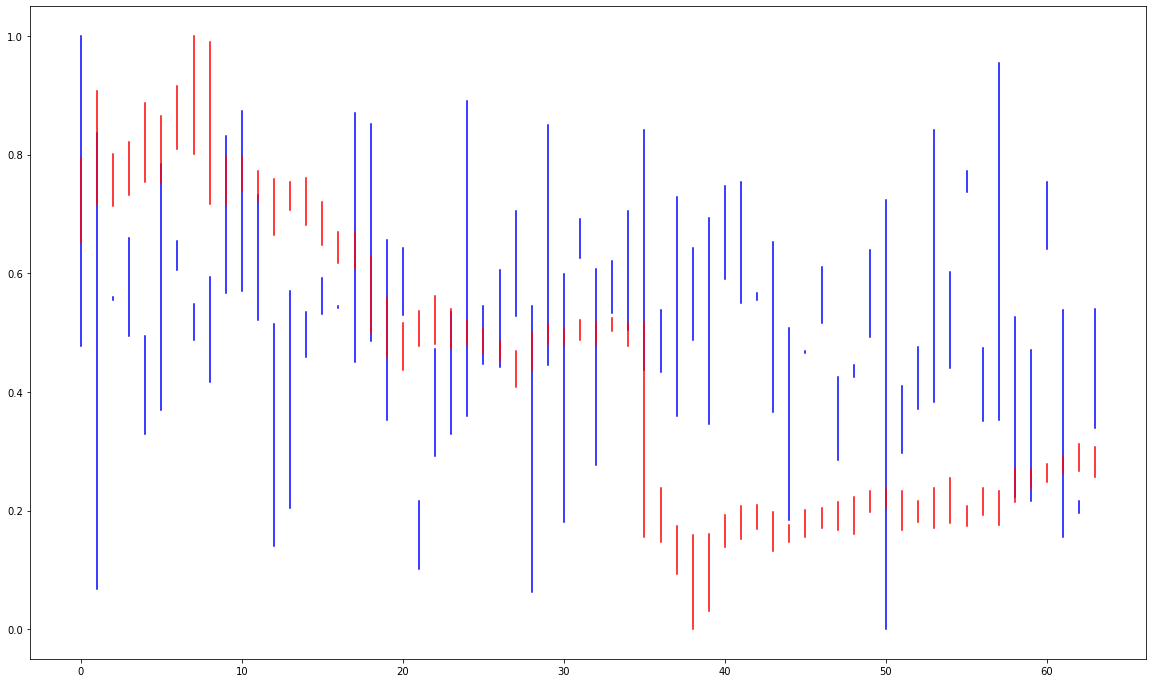

In [124]:



to_denoise, noise, step, orig  = get_random_seq_diffusion(M15_candles)






fig = plt.figure(figsize=(20, 12))


for i in range(prediction.shape[0]):
    plt.plot((i, i), (to_denoise[i, 0], to_denoise[i, 1]), color="blue")
    plt.plot((i, i), (orig[i, 0], orig[i, 1]), color="red")



In [62]:

# eval prediction - show candles

def binVec2Float(input, bin_size):
    vec = np.power(2.0, np.arange(bin_size-1, -1, -1))

    output = []
    for i in input:
        x = np.round_(i) > 0
        output.append(np.dot(vec, x) / 2**bin_size)
    
    return np.array(output)
        
        
sample = get_random_seq(M15_candles)[0]

print(sample.shape)
print(tf.expand_dims(sample, axis=-1).shape)

prediction = model(tf.expand_dims(sample, axis=0), training=True)[0]
#prediction = model.predict(tf.expand_dims(sample, axis=0))[0]
print(sample.shape)

bin_size = 8
N = 3


#output_L = binVec2Float(prediction[:, :bin_size], bin_size)
#output_H = binVec2Float(prediction[:, bin_size:], bin_size)

#real_L = binVec2Float(sample[:, :bin_size], bin_size)
#real_H = binVec2Float(sample[:, bin_size:], bin_size)




fig = plt.figure(figsize=(20, 12))

for i in range(sample.shape[0]):
    plt.plot((i, i), (sample[i, 0], sample[i, 1]), color="blue")
    plt.plot((i, i), (prediction[i, 0], prediction[i, 1]), color="red")







#for i in range(10):
#    plt.plot(np.squeeze(prediction[i]), color="red")
    






InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

<Figure size 1440x864 with 0 Axes>

In [45]:
# Load weights


encoder.load_weights("encoder_RNN_64_3")
#encoder.save_weights("encoder_RNN_64_3")

5


In [ ]:
sample = get_random_seq(M15_candles)[0]

print(sample.shape)
print(tf.expand_dims(sample, axis=-1).shape)

prediction = encoder(tf.expand_dims(sample, axis=0), training=True)[0]

print(prediction)




In [ ]:





# Show layers output

"""

"""



inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)

mdl = encoder
       
layer_outputs = [layer.output for layer in mdl.layers[:]] 
generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_activations = Model(inputs=mdl.input, outputs=layer_outputs)
    activations = get_activations.predict(inp)



print("All activations:", len(activations))
for i in activations:
    print("Activations:", i.shape, np.amin(i), np.amax(i))
    
    
    
layer_i = 28
print((activations[layer_i][0].T).shape)
print((activations[layer_i][1].T).shape)

x1 = (activations[layer_i][0].T)
x2 = (activations[layer_i][1].T)

x = [np.array(x1), np.array(x2)]


#x = activations[0][0]
#print("x", x.shape)

#print("Min, max: ", np.min(x), np.max(x))
#print("AE: ", x[0, :24, :24])






fig = plt.figure(figsize=(24, 5))

plt.stairs(x[0].T, color="red")
plt.stairs(x[1].T-x[0].T, color="blue")

plt.axis('off')

print("Done")








In [ ]:
print(np.unique(Y_data, return_counts=True))

In [ ]:
# Show output interval

print("### ENCODER ###")
   
layer_outputs = [layer.output for layer in encoder.layers[:]] 

inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)


generate = True
if generate:
    get_activations = Model(inputs=encoder.input, outputs=layer_outputs)
    activations = get_activations.predict(inp)
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(encoder.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')



layer_num = 12
x = activations[5:9]
print(x[0].shape)

aspect_ratio = 64 / 16

x_count = 7
y_size = 128 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    x_shp = x[i][0].shape[0]
    y_shp = x[i][0].shape[2]
    tmp = tf.reshape(x[i][0], (x_shp, y_shp))
    fig.add_subplot(1, 5, i+1)
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    




print("Done")









In [ ]:
## show kernels


mdl = encoder

inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)

layer_weights = [layer.weights for layer in mdl.layers[:]] 

generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_weights_model = Model(inputs=mdl.input, outputs=layer_weights)
    weights = get_weights_model.predict(np.expand_dims(inp, axis=0))

layer_num = 10

weights = layer_weights[2]
print(weights)



#print(weights[layer_num].shape)

x = np.array(weights)[0]
x = np.transpose(x, (2, 0, 1, 3))[0]
x = np.transpose(x, (2, 1, 0))   # transpose



aspect_ratio = 64 / 64

x_count = 4
y_size = 32 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    fig.add_subplot(x.shape[0], x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')
    


print("Done")





In [ ]:
# Load model


model = load_model(projDir + 'models/' + exp_name)
print('Loaded')

In [180]:
# save model
exp_name = "2R_67_percent_inp128x10_outp1"
#model.save_weights(projDir + 'weights/' + exp_name + '.hdf5')
model.save(projDir + 'models/' + exp_name)

#encoder.save_weights(projDir + 'weights/encoder_2048_contrastive.hdf5')
#encoder.save(projDir + 'models/encoder_2048_contrastive')


print('Saved')



INFO:tensorflow:Assets written to: models/2R_67_percent_inp128x10_outp1\assets


INFO:tensorflow:Assets written to: models/2R_67_percent_inp128x10_outp1\assets


Saved
